### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea
import os
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import cv2
import copy
import random
import shutil
%matplotlib inline

plt.style.use('seaborn')
device = 'cuda' if torch.cuda.is_available() else 'cpu'


/tmp/ipykernel_43940/3356040203.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


## Q1

#### 1. Data Preparation

In [4]:
# function to convert the video into frames
def extract_frames(video_path, output_folder, duration=30):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Unable to open video file")
        return
    
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_rate = int(cap.get(cv2.CAP_PROP_FPS))
    
    end_frame = min(int(duration * frame_rate), total_frames)
    
    for frame_num in tqdm(range(end_frame)):
        ret, frame = cap.read()
        if not ret:
            break
        cv2.imwrite(os.path.join(output_folder, f"frame_{frame_num}.jpg"), frame)

    cap.release()
    
video_path = "./data/forest_gump.mp4"
output_folder = "./temp/forest_gump"

extract_frames(video_path, output_folder, duration=30)


  0%|          | 0/690 [00:00<?, ?it/s]

#### 2. Face Detection

In [13]:

IMG_PATH = './temp/forest_gump/'
img_files = os.listdir(IMG_PATH)
img_indices = np.argsort([int(i.split('_')[1].split('.')[0]) for i in img_files])
img_files = np.array(img_files)[img_indices]
img_files.shape

(690,)

In [15]:
face_detections = []

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
# detect faces in the extracted frames and save the images with the boundig box
# use these images to create a new video.

for i, img in tqdm(enumerate(img_files), total=len(img_files)):
    img = cv2.imread(os.path.join(IMG_PATH, img))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.05, minNeighbors=10, minSize=(30, 30))
    
    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
        
    # plt.imshow(img)
    # plt.show()
    plt.imsave(f'./outputs/forest_gump_faces/{i}.jpg', img)
        

  0%|          | 0/690 [00:00<?, ?it/s]

#### 3. Face detection visualization

In [39]:
def images_to_video(images_path, output_video_path, fps=20):
    num_images = len(os.listdir(images_path))
    images = [plt.imread(os.path.join(images_path, f"{i}.jpg")) for i in range(num_images)]
    first_image = images[0]
    height, width, _ = first_image.shape

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    for img in tqdm(images):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        out.write(img)

    out.release()
    
output_video_path = "./outputs/forest_gump_face.mp4"
images_to_video('./outputs/forest_gump_faces/', output_video_path)

#### 4. Association-based Tracking

In [55]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
all_faces = []
unique_faces = {}
last_face = []

def calculate_iou(box1, box2):
    x1_box1, y1_box1, x2_box1, y2_box1 = box1
    x1_box2, y1_box2, x2_box2, y2_box2 = box2
    
    x_intersection = max(x1_box1, x1_box2)
    y_intersection = max(y1_box1, y1_box2)
    w_intersection = max(0, min(x2_box1, x2_box2) - x_intersection)
    h_intersection = max(0, min(y2_box1, y2_box2) - y_intersection)
    
    area_intersection = w_intersection * h_intersection

    area_box1 = (x2_box1 - x1_box1) * (y2_box1 - y1_box1)
    area_box2 = (x2_box2 - x1_box2) * (y2_box2 - y1_box2)
    
    area_union = area_box1 + area_box2 - area_intersection
    iou = area_intersection / area_union if area_union > 0 else 0
    
    return iou

def get_max_faces(unique_faces):
    return max(unique_faces.values()) if len(unique_faces) != 0 else 0

for i, img in tqdm(enumerate(img_files), total=len(img_files)):
    img = cv2.imread(os.path.join(IMG_PATH, img))
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.05, minNeighbors=10, minSize=(30, 30))
        
    for (x, y, w, h) in faces:
        match_found = None
        
        if len(last_face) > 0:
            for (x_last, y_last, w_last, h_last) in last_face:
                # this iou is with current face and all the last faces one by one
                # if the current face has iou > 0.5 with one of the last face then we can say that it is a match
                iou = calculate_iou([x, y, x+w, y+h], [x_last, y_last, x_last+w_last, y_last+h_last])
                # print(iou)
                if iou > 0.25:
                    # match found, break now
                    match_found = (x_last, y_last, w_last, h_last) 
                    break                   
                
        if match_found:
            # assign the index of the matched last face to this face
            unique_faces[(x, y, w, h)] = unique_faces[(x_last, y_last, w_last, h_last)]
        else:
            # increment the max index till now and assign it to this face
            unique_faces[(x, y, w, h)] = get_max_faces(unique_faces) + 1
            
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)    
        cv2.putText(img, str(unique_faces[(x, y, w, h)]), (x-20, y+20), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    
    if faces is not None:
        last_face = copy.deepcopy(faces)
        
    plt.imsave(f'./outputs/forest_gump_tracking/{i}.jpg', img)

  0%|          | 0/690 [00:00<?, ?it/s]

In [56]:
output_video_path = "./outputs/forest_gump_face_tracking.mp4"
images_to_video('./outputs/forest_gump_tracking/', output_video_path)

  0%|          | 0/690 [00:00<?, ?it/s]

The number of unique tracks generated was 85. Ths number is very high because of (i) multiple wrong face detections (ii) discontinuity in the face detections of characters. 

People get associated with the same index only if their position doesn't change drastically across mutiple frames. There are instances where the camera angle changes and the girl seems to be far behind than before and hence the detected face gets associated with a new index. This problem can probably be solved if we use the features of the detected face for comparison and not just IoU.

Finally, a single character gets associated with multiple index by the end of the video, for reasons stated above.

## Q2

### 1. Data Preparation

In [9]:
!kaggle datasets download -d haziqasajid5122/yolov8-finetuning-dataset-ducks -p /scratch/fk/ --unzip

100%|███████████████████████████████████████▉| 490M/492M [00:28<00:00, 14.9MB/s]
100%|████████████████████████████████████████| 492M/492M [00:28<00:00, 18.1MB/s]


### 2. Understanding YOLO models

<img src='https://assets-global.website-files.com/5d7b77b063a9066d83e1209c/63c697965a86db36ab528b16_YOLO%20timeline-min.jpg' width='30%'>

Single-shot detectors like YOLO (You Only Look Once) differ from the R-CNN (Region-based Convolutional Neural Network) series primarily in their approach to object detection.

In R-CNN, the image is first processed to generate region proposals, which are then fed into a convolutional neural network (CNN) for feature extraction and classification. This multi-step process can be computationally expensive and time-consuming. Whereas, YOLO takes a single-pass approach. It divides the image into a grid and predicts bounding boxes and class probabilities for objects directly from this grid. This results in faster inference times compared to R-CNN, as YOLO only requires a single forward pass through the network.

Different versions of YOLO:

1. **YOLOv3**: YOLOv3 introduces several improvements over its predecessors, including the use of feature pyramid networks (FPNs) to extract features at multiple scales, which improves detection accuracy for objects of different sizes. It also incorporates additional techniques such as spatially-aware darknet, which enhances the network's ability to localize objects accurately.

2. **YOLOv4**: YOLOv4 further improves upon YOLOv3 by introducing various architectural changes and optimization techniques. It incorporates features such as CSPDarknet53 as the backbone network, which improves feature extraction efficiency, and the use of multi-scale prediction heads for detecting objects at different scales more effectively. Additionally, YOLOv4 incorporates various training techniques like data augmentation and regularization to improve model generalization and robustness.

3. **YOLOv5**: YOLOv5 is a recent version that introduces a simpler and more efficient architecture compared to previous versions. It utilizes a lightweight backbone network based on EfficientNet and focuses on model scaling and optimization to achieve high performance on various platforms. YOLOv5 also introduces the concept of ensemble methods, where multiple YOLO models of different sizes are combined to improve detection accuracy further.


### 3. Hands on with ultralytics library


In [2]:
from ultralytics import settings
from ultralytics import YOLO

# settings.update({'runs_dir': '/scratch/fk/runs'})
# settings.update({'datasets_dir': '/scratch/fk/datasets'})
# settings.update({'weights_dir': '/scratch/fk/weights'})

print(settings)

{'settings_version': '0.0.4', 'datasets_dir': '/scratch/fk/datasets', 'weights_dir': '/scratch/fk/weights', 'runs_dir': '/scratch/fk/runs', 'uuid': 'e696c75e3c76056947386ecd811405137e6c97abac6177aeda1d55691cba8b42', 'sync': True, 'api_key': '', 'openai_api_key': '', 'clearml': True, 'comet': True, 'dvc': True, 'hub': True, 'mlflow': True, 'neptune': True, 'raytune': True, 'tensorboard': True, 'wandb': True}


In [2]:
# model_8n = YOLO('yolov8n.yaml').to(device)


In [5]:
#  iterate over all the weights and count them
def get_num_parameters(model):
    counter = 0
    for param in model.parameters():
        counter += param.numel()
    print(f"Number of parameters: {counter:,}")

# iterate over all the layers and find the nn.Conv2d 
def get_num_conv_layers(model):
    counter = 0
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            counter +=1
    print(f"Number of conv layers: {counter}")
    
get_num_parameters(model_8n)
get_num_conv_layers(model_8n)


Number of parameters: 3,157,200
Number of conv layers: 64


In [6]:
model_8m = YOLO('yolov8m.yaml').to(device)
get_num_parameters(model_8m)
get_num_conv_layers(model_8m)


Number of parameters: 25,902,640
Number of conv layers: 84


| Model         | # parameters  | # conv layers |
|----------     |---------------|---------------|
| yolo-v8-nano  | 3,157,200     | 64            |
| yolo-v8-medium| 25,902,640    | 84            |

From the above table, we can see that yolo-v8-medium has about 8 times more parameters than yolo-v8-nano and about 1.3 times more number of conv layers.

#### 4. Training YOLO variants

In [14]:

# code to create the splits
create_splits = False

if create_splits:
    files = os.listdir('/scratch/fk/images/train/')
    files = random.sample(files, 100)

    for f in files:
        f = f.split('.')[0]
        shutil.copy(f'/scratch/fk/images/train/{f}.png', f'/scratch/fk/data_100/images/train/{f}.png') # copy images
        shutil.copy(f'/scratch/fk/labels/train/{f}.txt', f'/scratch/fk/data_100/labels/train/{f}.txt') # copy labels
        

##### Training on data-100

data-100 contains 100 training images and 40 images for validation. It is a subset of the original dataset.

>path: /scratch/fk/data-100 \
>config_path: /scratch/fk/config_100.yaml

In [ ]:
# yolo-8n scratch
model = YOLO('yolov8n.yaml').to(device)
model.train(data='/scratch/fk/config_100.yaml', epochs=20, workers=5)


In [ ]:
# yolo-8n pretrained
model = YOLO('yolov8n.pt').to(device)
model.train(data='/scratch/fk/config_100.yaml', epochs=20, workers=5)


In [ ]:
# yolo-8m pretrained
model = YOLO('yolov8m.pt').to(device)
model.train(data='/scratch/fk/config_100.yaml', epochs=20, workers=5)

##### Training on data-400

data-400 is the original dataset itself.
> path: /scratch/fk/data_400
> config_path: /scratch/fk/config_400.yaml

In [ ]:
# yolo-8n scratch
model = YOLO('yolov8n.yaml').to(device)
model.train(data='/scratch/fk/config_400.yaml', epochs=20, workers=5)


In [ ]:
# yolo-8n pretrained
model = YOLO('yolov8n.pt').to(device)
model.train(data='/scratch/fk/config_400.yaml', epochs=20, workers=5)

In [ ]:
# yolo-8m pretrained
model = YOLO('yolov8m.pt').to(device)
model.train(data='/scratch/fk/config_400.yaml', epochs=20, workers=5)

#####  Results

<table>
  <tr>
    <td>Model</td>
    <td colspan="2">mAP50</td>
    <td colspan="2">Precision</td>
    <td colspan="2">Recall</td>
  </tr>
  <tr>
    <td></td>
    <!-- <td>Yolo-v8-nano-scratch</td> -->
    <td colspan="1">data-100</td>
    <td colspan="1">data-400</td>
    <td colspan="1">data-100</td>
    <td colspan="1">data-400</td>
    <td colspan="1">data-100</td>
    <td colspan="1">data-400</td>
  </tr>
  <tr>
    <td>Yolo-v8-nano-scratch</td>
    <td>0.0504</td>
    <td>0.1986</td>
    <td>0.00230</td>
    <td>0.2994</td>
    <td>0.6153</td>
    <td>0.2692</td>
  </tr>

  <tr>
    <td>Yolo-v8-nano-pt</td>
    <td>0.6408</td>
    <td>0.7690</td>
    <td>0.6302</td>
    <td>0.7691</td>
    <td>0.9807</td>
    <td>0.80342</td>
  </tr>

  <tr>
    <td>Yolo-v8-medium-pt</td>
    <td>0.7127</td>
    <td>0.68392</td>
    <td>0.630</td>
    <td>0.727</td>
    <td>0.84615</td>
    <td>0.7307</td>
  </tr>

</table>

#### Observations

1. Increasing dataset size seems to generally improve performance metrics such as mAP50, Precision, and Recall. For example:

    - For the model Yolo-v8-nano-scratch, as the dataset size increases from data-100 to data-400, the mAP50, Precision, and Recall values also tend to increase.
    - Similarly, for the other models Yolo-v8-nano-pt and Yolo-v8-medium-pt, increasing the dataset size from data-100 to data-400 also leads to improvements in performance metrics. 

    <br>

2. The bigger model, Yolo-v8-medium-pt, does not always perform better compared to the smaller models (Yolo-v8-nano-scratch and Yolo-v8-nano-pt). While the Yolo-v8-medium-pt model has higher mAP50 and Recall compared to Yolo-v8-nano-scratch, it does not consistently outperform the other models in terms of Precision. 
Hence, we can conclude that for a large model like Yolo-v8-medium we would need a lot more data to get better results than Yolo-v8-nano.

##### Visualizing results

In [16]:
images = os.listdir('/scratch/fk/data_400/images/val/')
images = random.sample(images, 16)
images = [os.path.join('/scratch/fk/data_400/images/val/', i) for i in images]

with torch.no_grad():
    results = model(images)

for i, result in enumerate(results):
    boxes = result.boxes.xywh.cpu().numpy()
    img = cv2.imread(images[i])
    img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for box in boxes:
        x, y, w, h = box 
        cv2.rectangle(img, (int(x), int(y)), (int(x + w), int(y + h)), (255, 0, 0), 2)
        
    plt.imsave(f'./outputs/{i}.png', img)


0: 640x640 (no detections), 1.6ms
1: 640x640 (no detections), 1.6ms
2: 640x640 1 duck, 1.6ms
3: 640x640 (no detections), 1.6ms
4: 640x640 1 duck, 1.6ms
5: 640x640 1 duck, 1.6ms
6: 640x640 1 duck, 1.6ms
7: 640x640 1 duck, 1.6ms
8: 640x640 1 duck, 1.6ms
9: 640x640 1 duck, 1.6ms
10: 640x640 1 duck, 1.6ms
11: 640x640 1 duck, 1.6ms
12: 640x640 2 ducks, 1.6ms
13: 640x640 1 duck, 1.6ms
14: 640x640 1 duck, 1.6ms
15: 640x640 3 ducks, 1.6ms
Speed: 3.4ms preprocess, 1.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


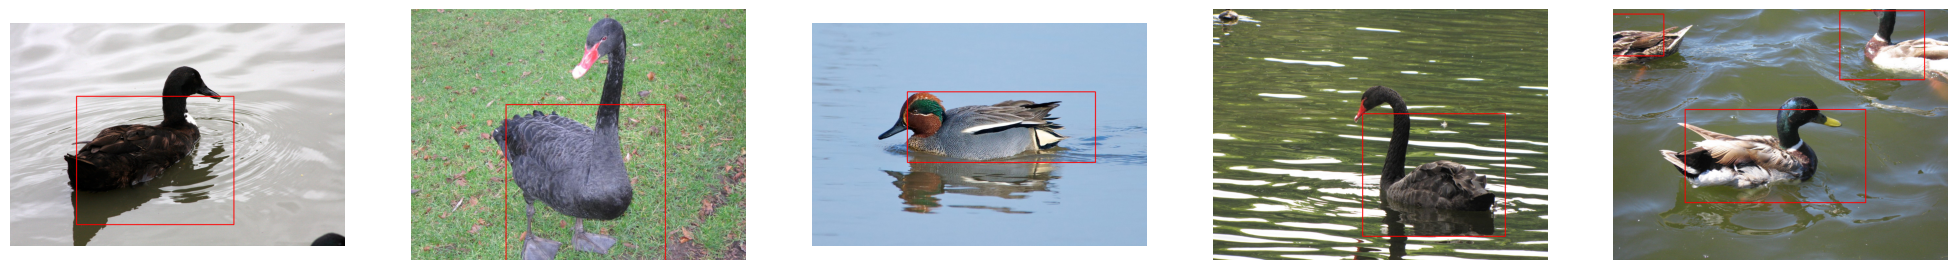

In [21]:
plt.figure(figsize=(25, 8))

for i in range(5):
    plt.subplot(1, 5, i + 1)
    img = plt.imread(f'./outputs/{i}.png')
    plt.imshow(img)
    plt.axis('off')
    
plt.show()

We can observe that the model performs well on the given images, however it slightly struggles when the duck covers most part of the image (as shown in the 2nd diagram). We can expect better results if we can add more data of varying scales.

#### 5. Impact of Augmentations

In [ ]:
model = YOLO('yolov8n.pt').to(device)
model.train(data='/scratch/fk/config_400.yaml', epochs=20, workers=5, augment=False)